In [262]:
!pip install voila
!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 5.9MB 2.3MB/s 
     |████████████████████████████████| 921kB 34.4MB/s 
     |████████████████████████████████| 184kB 46.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?


In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 15.5MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 358kB 20.1MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 40kB 5.3MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 2.6MB 21.1MB/s 
ERROR: fastai 2.0.8 has requirement pandas>=1.1.0, but you'll have pandas 1.0.5 which is incompatible.


In [3]:
from fastbook import *
from fastai.vision.widgets import *

## Downloading the image data

In [5]:
%cd drive/My\ Drive/Projects/RASH

/content/drive/My Drive/Projects/RASH


In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c1918561255b42869fbba319742dd127')

In [7]:
search_images_bing

<function fastbook.search_images_bing>

In [8]:
disease_types = 'kawasaki disease', 'normal', 'eczema disease', 'fifth disease'
checks = 'skin', 'lips and mouth', 'hands and feet', 'eyes'

In [9]:
path = Path('disease')

In [ ]:
# if not path.exists():
#     path.mkdir()
#     for o in disease_types:
#         dest = (path/o)
#         dest.mkdir(exist_ok=True)
#         for i in checks:
#           results = search_images_bing(key, f'{o} {i}')
#           download_images(dest, urls=results.attrgot('content_url'))

## Preprocessing

In [223]:
fns = get_image_files(path)
fns

(#664) [Path('disease/kawasaki disease/00000003.png'),Path('disease/kawasaki disease/00000004.jpeg'),Path('disease/kawasaki disease/00000010.jpeg'),Path('disease/kawasaki disease/00000009.gif'),Path('disease/kawasaki disease/00000014.gif'),Path('disease/kawasaki disease/00000021.JPG'),Path('disease/kawasaki disease/00000034.png'),Path('disease/kawasaki disease/00000033.gif'),Path('disease/kawasaki disease/00000073.jpg'),Path('disease/kawasaki disease/00000081.gif')...]

In [224]:
failed = verify_images(fns)
failed

(#0) []

In [225]:
failed.map(Path.unlink);

In [226]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [227]:
disease = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [228]:
dls = disease.dataloaders(path)

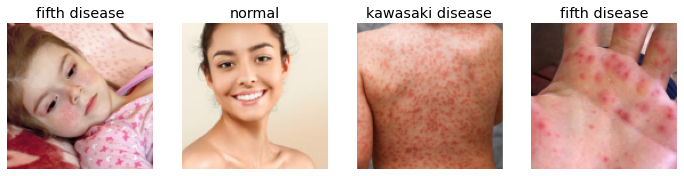

In [229]:
dls.valid.show_batch(max_n=4, nrows=1)

In [230]:
disease = disease.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = disease.dataloaders(path)

In [231]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,2.010799,1.694827,0.553030,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.403406,1.230791,0.454545,00:12
1,1.218784,1.157816,0.378788,00:12
2,1.063039,1.159277,0.348485,00:12
3,0.935037,1.109736,0.325758,00:12
4,0.829758,1.051291,0.318182,00:12
5,0.753666,1.067245,0.318182,00:12


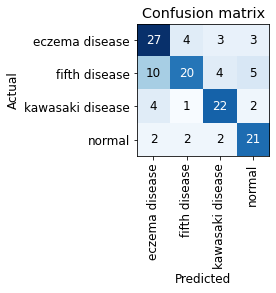

In [232]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

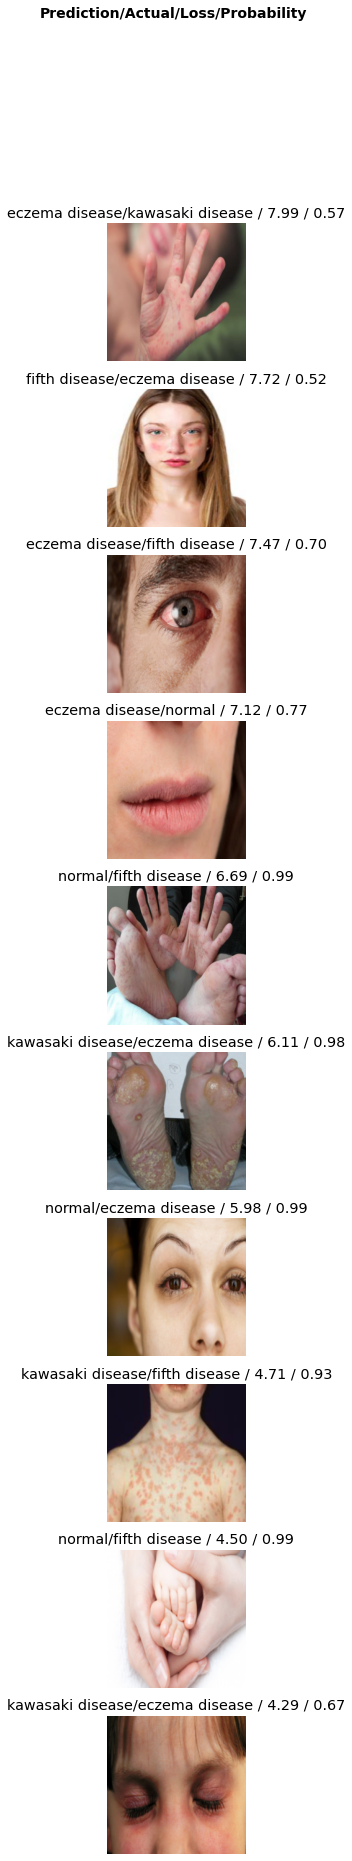

In [236]:
interp.plot_top_losses(10
                       , nrows=10)

In [234]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [235]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [237]:
learn.export()

In [238]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [241]:
learn_inf = load_learner(path/'export.pkl')

In [246]:
learn_inf.predict('image/image.jpeg')

('eczema disease', tensor(0), tensor([0.5295, 0.0223, 0.3876, 0.0606]))

In [243]:
learn_inf.dls.vocab

(#4) ['eczema disease','fifth disease','kawasaki disease','normal']

In [247]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [253]:
btn_upload = SimpleNamespace(data = ['image/image.jpeg'])

In [254]:
img = PILImage.create(btn_upload.data[-1])

In [255]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [256]:
pred,pred_idx,probs = learn_inf.predict(img)

In [257]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: eczema disease; Probability: 0.5295')

In [258]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [259]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [260]:
btn_upload = widgets.FileUpload()

In [261]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [1]:
!jupyter serverextension enable voila —sys-prefix

Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
